In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
import numpy as np
from typing import List, Union
import os
from matplotlib import colormaps
import matplotlib as mpl
import tqdm
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("/home/qb/Desktop/GPs")

from data import GaussianPreprocessor, SequenceDataset

In [2]:
# x1 = np.linspace(1, 100, 100)
# x2 = np.linspace(-100, 100, 100)
# x3 = np.random.randn(100)
# y = np.exp(x1 / x2 * x3)
# t = np.linspace(1, 10, 100)
# print(np.stack([x1, x2, x3], axis=1).shape)
      
# df = pd.DataFrame(np.stack([x1, x2, x3, y, t], axis=1), columns=['x1', 'x2', 'x3', 'y', 'timestamp'])

# /home/qb/Desktop/GPs/Dataset/C1-1001_performance_20220915103555.csv
# /home/qb/Desktop/GPs/Dataset/C1-1001_performance_20220915151041.csv
# print(df)

# cols = ["1", "2"]

# include_ids = {1: [{"fn" : "C1-1001_performance_20220915103555.csv"}], 2: [{"fn": 'C1-1001_performance_20220915151041.csv'}]}

# include_ids = {1: [{"fn": "toy_1.csv"}], 2: [{"fn": 'toy_2.csv'}]}

# preprocessor = GaussianPreprocessor(["/home/qb/Desktop/GPs/Dataset/"], masks=["brake_percentage"], normalized_columns=['engine_rpm', 'imu_forward_acceleration', "chassis_acc", "vehicle_speed", 'drive_motor_torque_nm', 'speed_cmd'], one_hot_columns=["gear_location_num"])

# dataset = SequenceDataset(["/home/qb/Desktop/GPs/Dataset/"], 100, preprocessor=preprocessor, include_ids=include_ids)

# lb = df.min()
# ub = df.max()

# lb = pd.DataFrame(np.stack([np.ones([100, 1]), 0.5 * np.ones([100, 1]), -1.0 * np.ones([100, 1])], axis=1).squeeze(), columns=['1', '2', '3'])
# lb = pd.DataFrame(np.stack([np.ones([1, 1]), 0.5 * np.ones([1, 1]), -1.0 * np.ones([1, 1])], axis=1).reshape(-1, 3), columns=['1', '2', '3'])

 

# df = df[cols].apply(lambda x: (x - lb[cols]).div(ub[cols] - lb[cols]) * 2.0  - 1.0, axis=1)

# print(df)


# df[cols].apply(lambda x: pd.Series([1,2,3]), axis=1)


# print(dataset.data_d[1].columns)



In [3]:
# print(torch.tensor(dataset.data_d[1].iloc[5:10].to_numpy()))

In [4]:
# data = dataset.sequences

# # print(data)

# for key, lst in dataset.sequences.items():
#     print("key {}".format(key))
#     data[key] = [lst[i] for i in np.random.permutation(len(lst))]
    
# for key, lst in data.items():
    
#     curr_idx = 0
    
#     while curr_idx < len(lst):
#         x_batch_list = []
#         y_batch_list = []
        
#         while curr_idx < len(lst) and len(x_batch_list) < 100:
#             seq_df = dataset.data_d[key].iloc[lst[curr_idx]]
            
#             x_tensor = torch.tensor([seq_df.to_numpy()])
            
#             x_batch_list.append(x_tensor)
            
#             curr_idx += 1
        
#         x_batch = torch.cat(x_batch_list, dim=0)
        
#         print(x_batch.shape)






In [5]:
def ReadCSV(root: str):
    csv_files = []

# Iterate directory
    for path in os.listdir(root):
        # check if current path is a file
        if os.path.isfile(os.path.join(root, path)) and path.endswith('.csv'):
            csv_files.append(path)
            
    raw_data = None
    
    for f in csv_files:
        if raw_data is not None:
            raw_data = pd.concat([raw_data, pd.read_csv(os.path.join(root, path))], axis=0, ignore_index=True)
        else:
            raw_data = pd.read_csv(os.path.join(root, path))
    
    raw_data.reset_index()
    return raw_data.drop_duplicates()

In [6]:
def RemoveUnwantedData(x: pd.DataFrame):
    x = x[x["brake_percentage"] == 0]
    return x

In [7]:
def AddRelativeTime(x: pd.DataFrame):
    if "dt" in x.columns:
        return x
    
    if "timestamp" not in x.columns:
        raise Exception("Not timestamp")
        
    num_data_point = x.shape[0]
        
    relative_time = x.iloc[1:num_data_point]["timestamp"].to_numpy() - x.iloc[0:num_data_point-1]["timestamp"].to_numpy()
    relative_time = np.append(relative_time, 0.0)   
    
    x['dt'] = relative_time
    return x

In [8]:
def TimeSeriesData(raw_data: pd.DataFrame, state_columns: List[str], observ_columns: List[str]):
    
    data = None
    if "dt" not in raw_data.columns:
        data = AddRelativeTime(raw_data)
    else:
        data = raw_data
        
    num_data_point = data.shape[0]
    
    
    
    if(any(entity not in data.columns for entity in state_columns)):
        raise Exception("Unknown state")
    
    if(any(entity not in data.columns for entity in observ_columns)):
        raise Exception("Unknown observation")
    
    x_index = np.logical_and([data["dt"] < 0.5], [data["dt"] > 0.0]).flatten()
    y_index = np.append(x_index, x_index[-1])[1:].flatten()
        
    X = data[x_index][state_columns + ["dt"]]
    Y = data[y_index][observ_columns]

        
    return X, Y, x_index, y_index

In [9]:
def NormalizeData(x: pd.DataFrame, shifter: Union[None, np.array] = None, normalizer: Union[None, np.array] = None):
    X = x[x.columns[x.columns != "timestamp"]]
    timestamp = x["timestamp"]
    
    if shifter is None:
        shifter = X.min()
        
    X = X - shifter
    
    if normalizer is None:
        normalizer = X.max()

    X = 2 * (X / normalizer) - 1

    return pd.concat([X, timestamp], axis=1), shifter, normalizer

def DeNormalizeData(x: np.array, shifter: np.array, normalizer: np.array):
    return (x + 1.0) / 2.0 * normalizer + shifter

In [10]:
root = "/home/qb/workspace/Data/"

# state_columns = ['engine_rpm', 'imu_forward_acceleration', "chassis_acc", "vehicle_speed", 'drive_motor_torque_nm', 'gear_location_num', 'speed_cmd']
state_columns = ['engine_rpm', "vehicle_speed", 'drive_motor_torque_nm', 'gear_location_num', 'speed_cmd']

# observ_columns = ['engine_rpm', 'imu_forward_acceleration', "chassis_acc", "vehicle_speed", 'drive_motor_torque_nm', 'gear_location_num']

observ_columns = ['imu_forward_acceleration', "chassis_acc"]

input_dim = len(state_columns) + 1
output_dim = len(observ_columns)

In [11]:
raw_data = ReadCSV(root)

raw_data = RemoveUnwantedData(raw_data)

auto_data = raw_data[raw_data["driving_mode"] == 1]
manual_data = raw_data[raw_data["driving_mode"] == 0]
em_data = raw_data[raw_data["driving_mode"] == 4]

auto_data_normalized, shifter, normalizer = NormalizeData(auto_data)

auto_data_normalized = AddRelativeTime(auto_data_normalized)

auto_data_x, auto_data_y, x_index, y_index = TimeSeriesData(auto_data_normalized, state_columns, observ_columns)


train_x, _, train_y, _ = train_test_split(auto_data_x, auto_data_y, test_size=0.2, random_state=1080)


train_x_index = train_x.index.tolist()

In [12]:
from sklearn.cluster import KMeans


print(train_x.shape)
print(train_y.shape)
print(train_x.columns)
print(train_y.columns)

train_set = pd.concat([train_x.reset_index(drop=True), train_y.reset_index(drop=True)], axis=1, ignore_index=True)

print(train_x)
print(train_y)
print(train_set)


num_inducing_points = 1000
num_clusters = 100000

KM = True


(145522, 6)
(145522, 2)
Index(['engine_rpm', 'vehicle_speed', 'drive_motor_torque_nm',
       'gear_location_num', 'speed_cmd', 'dt'],
      dtype='object')
Index(['imu_forward_acceleration', 'chassis_acc'], dtype='object')
        engine_rpm  vehicle_speed  drive_motor_torque_nm  gear_location_num  \
284096   -0.359946       0.173821              -0.958333           0.714286   
196369   -0.910690      -0.986629              -0.833333          -1.000000   
103400   -0.487145      -0.336383              -0.187500           0.428571   
190408   -0.901218      -0.985222              -0.833333          -1.000000   
45763    -0.916103      -0.987333              -0.812500          -1.000000   
...            ...            ...                    ...                ...   
195106   -0.909337      -0.986629              -0.812500          -1.000000   
136567   -0.181326       0.558058               0.020833           1.000000   
69335    -0.338295      -0.598874              -0.583333         

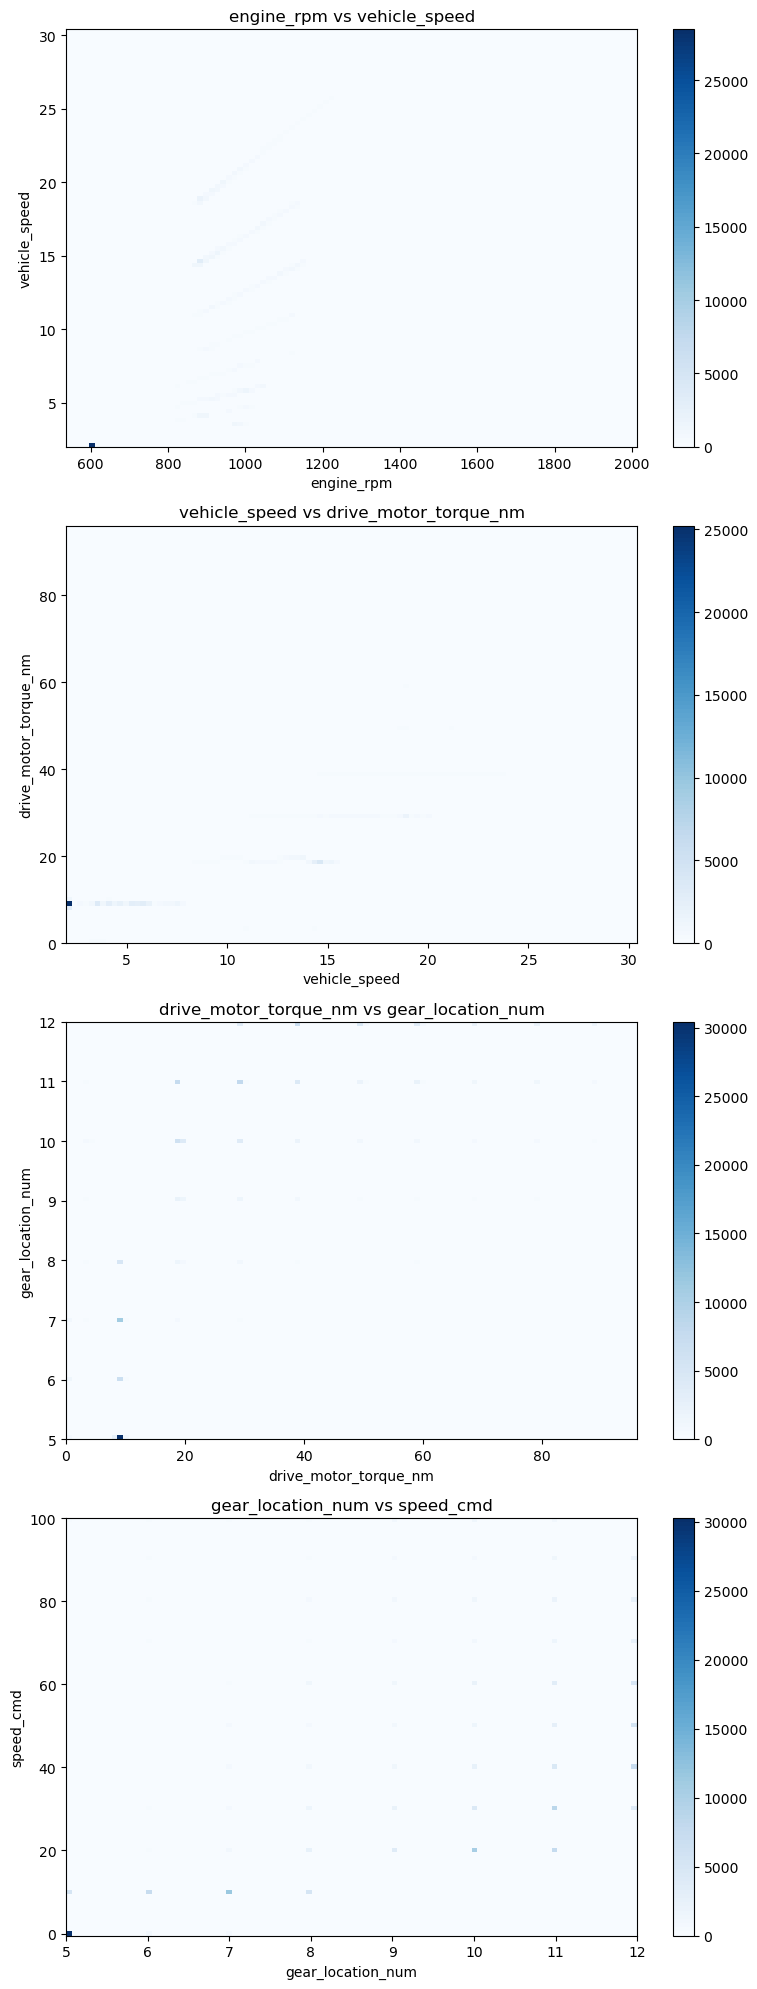

In [13]:

%matplotlib inline
fig = plt.figure(figsize=(8, 20))

blues = mpl.colormaps['Blues'].resampled(100)
    
for i in range(input_dim - 2):
    ax = fig.add_subplot(input_dim - 2, 1, i + 1)
    h2 = ax.hist2d(auto_data[state_columns[i]].to_numpy(), auto_data[state_columns[i+1]].to_numpy(), bins=100, cmap=blues)
    ax.set_xlabel(state_columns[i])
    ax.set_ylabel(state_columns[i + 1])
    ax.set_title(state_columns[i] + " vs " + state_columns[i+1])

    plt.colorbar(h2[3])
    
plt.tight_layout() 
plt.show()

In [14]:
if KM:
    kmeans = KMeans(n_clusters=num_clusters, random_state=1080).fit(train_set)

    print(kmeans.cluster_centers_.shape)

    new_train_x = kmeans.cluster_centers_[:, :-2]
    new_train_y = kmeans.cluster_centers_[:, -2:]

    train_x = torch.tensor(new_train_x, dtype=torch.float).cuda()
    train_y = torch.tensor(new_train_y, dtype=torch.float).cuda()

else:
    train_x = torch.tensor(train_x.to_numpy(), dtype=torch.float).cuda()
    train_y = torch.tensor(train_y.to_numpy(), dtype=torch.float).cuda()


print(train_x.shape)
print(train_y.shape)

KeyboardInterrupt: 

In [ ]:
print(train_x[1])

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8, 20))

blues = mpl.colormaps['Blues'].resampled(100)
    
for i in range(input_dim - 2):
    ax = fig.add_subplot(input_dim - 2, 1, i + 1)
    h2 = ax.hist2d(train_x[:, i].cpu().numpy(), train_x[:, i+1].cpu().numpy(), bins=100, cmap=blues)
    ax.set_xlabel(state_columns[i])
    ax.set_ylabel(state_columns[i + 1])
    ax.set_title(state_columns[i] + " vs " + state_columns[i+1])

    plt.colorbar(h2[3])
    
plt.tight_layout() 
plt.show()


In [ ]:
# class MultitaskGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
#         self.num_tasks = train_y.shape[1]
#         self.mean_module = gpytorch.means.MultitaskMean(
#             gpytorch.means.ConstantMean(), num_tasks=self.num_tasks
#         )
#         self.covar_module = gpytorch.kernels.MultitaskKernel(
#             gpytorch.kernels.RBFKernel(), num_tasks=self.num_tasks, rank=1
#         )

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[1]).cuda()
# model = MultitaskGPModel(train_x, train_y, likelihood).cuda()

In [ ]:
num_latents = 100
latent_features = 30
num_tasks = train_y.shape[1]

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, latent_features, train_x.shape[1])

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
model = MultitaskGPModel().cuda()
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).cuda()

In [ ]:
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 2000


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.02)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))


writer = SummaryWriter()

batch_size = 100

num_fold = train_x.shape[0] // batch_size

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    
    optimizer.zero_grad()
    
    start_index = 0
    
    losses = []
    
    for i in range(num_fold):
        batch = train_x[int(start_index) : int(start_index + batch_size), :]
        target = train_y[int(start_index) : int(start_index + batch_size), :]
        output = model(batch)
        losses.append(-mll(output, target))
        losses[-1].backward()
        start_index += batch_size
    
    total_loss = 0
    for loss in losses:
        total_loss += loss.item()
    
    epochs_iter.set_postfix(loss=total_loss)
    writer.add_scalar('Loss/train', total_loss, i)
    optimizer.step()
    
writer.close()

In [ ]:
# for name, param in model.named_parameters():
#     print(name, type(param), param.size())

In [ ]:
# this is for running the notebook in our testing framework
# import os
# smoke_test = ('CI' in os.environ)
# training_iterations = 2 if smoke_test else 100


# # Find optimal model hyperparameters
# model.train()
# likelihood.train()

# # Use the adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# # "Loss" for GPs - the marginal log likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# for i in tqdm(range(training_iterations)):
#     optimizer.zero_grad()
#     output = model(train_x)
#     loss = -mll(output, train_y)
#     loss.backward()
#     print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
#     optimizer.step()

# state_dict = torch.load('multitask_approx_gp_onestep.pth')
# model.load_state_dict(state_dict)

In [ ]:
# torch.save(model.state_dict(), 'multitask_approx_gp_model_onestep.pth')
# torch.save(likelihood.state_dict(), 'multitask_approx_gp_likelihood_onestep.pth')


# model_state_dict = torch.load('multitask_approx_gp_model_onestep.pth')
# print(model_state_dict)
# model.load_state_dict(model_state_dict)

In [ ]:
test_data = None
test_x = None
test_y = None
test_t = None
observed_pred = None
lower = None
upper = None
overlap_y = None
torch.cuda.empty_cache()


start_index = None
end_index = 0
for i, b in enumerate(y_index):
    if b and not start_index:
        start_index = i
    if not b:
        end_index = i - 1
        test_data = auto_data.iloc[start_index:end_index]
#         if end_index - start_index > 100 and test_data["chassis_acc"].mean() > 0.2:
        if end_index - start_index > 100 and test_data["chassis_acc"].mean() > 0.1:
            break
        else:
            start_index = i + 2
            
print(start_index)
print(end_index)

# if end_index - start_index > 3500:
#     start_index = end_index - 3500

# print(start_index)
# print(end_index)

test_data = auto_data_normalized.iloc[start_index:end_index]

test_x = test_data[state_columns + ["dt"]]

test_y = test_data[observ_columns]
test_t = auto_data.iloc[start_index:end_index]["timestamp"]

test_x_index = test_x.index.tolist()

overlap = set(train_x_index).intersection(set(test_x_index))

overlap_t = test_t.loc[overlap]
overlap_y = test_y.loc[overlap][observ_columns]

print(overlap_t)
print(overlap_y)

test_x = torch.tensor(test_x.to_numpy(), dtype=torch.float).cuda()
test_y = torch.tensor(test_y.to_numpy(), dtype=torch.float)


print(test_x.shape)
print(test_y)

test_y = DeNormalizeData(test_y.numpy(), shifter[observ_columns].to_numpy(), normalizer[observ_columns].to_numpy())
overlap_y = DeNormalizeData(overlap_y.to_numpy(), shifter[observ_columns].to_numpy(), normalizer[observ_columns].to_numpy())

In [ ]:
# fig = plt.figure(figsize=(8, 50))
# blues = mpl.colormaps['Blues'].resampled(100)

# for i in range(input_dim - 2):
#     ax = fig.add_subplot(input_dim - 2, 1, i + 1)
#     h2d = ax.hist2d(test_x[state_columns[i]].to_numpy(), test_x[state_columns[i+1]].to_numpy(), bins=100, cmap=blues)
#     ax.set_xlabel(state_columns[i])
#     ax.set_ylabel(state_columns[i+1])
#     ax.set_xlabel(state_columns[i])
#     ax.set_ylabel(state_columns[i + 1])
#     ax.set_title(state_columns[i] + " vs " + state_columns[i+1])
#     plt.colorbar(h2d[3])

    
# plt.tight_layout() 
# plt.show()



In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()


train_x = None
train_y = None

lowers = []
uppers = []
means = []
ts = []
ys = []

test_batch_size = test_x.shape[0] // num_fold

start_index = int(0)
for i in range(num_fold):
    batch = test_x[start_index : start_index + test_batch_size]
    ts.append(test_t.iloc[start_index: start_index + test_batch_size])
    ys.append(test_y[start_index: start_index + test_batch_size])
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(batch))
        lower, upper = pred.confidence_region()
        means.append(DeNormalizeData(pred.mean.cpu().numpy(), shifter[observ_columns].to_numpy(), normalizer[observ_columns].to_numpy()))
        lowers.append(DeNormalizeData(lower.cpu().detach().numpy(), shifter[observ_columns].to_numpy(), normalizer[observ_columns].to_numpy()))
        uppers.append(DeNormalizeData(upper.cpu().detach().numpy(), shifter[observ_columns].to_numpy(), normalizer[observ_columns].to_numpy()))
    start_index += test_batch_size
    
lowers = np.array(lowers).reshape(-1, 2)
uppers = np.array(uppers).reshape(-1, 2)
means = np.array(means).reshape(-1, 2)
ts = np.array(ts).reshape(-1, 1).squeeze()
ys = np.array(ys).reshape(-1, 2)

print(lowers.shape)
print(means.shape)
print(ts.shape)
print(upper.shape)

In [ ]:
%matplotlib inline



with torch.no_grad():

        
    f = plt.figure(figsize=(10, 30))
    for i in range(test_y.shape[1]):
        ax = f.add_subplot(test_y.shape[1], 1, i+1)

        # Get upper and lower confidence bounds
#         lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(ts, ys[:, i], 'k*', markersize=2, label='predictions')
        # Plot predictive means as blue line
        ax.plot(ts, means[:, i], 'bo', markersize=2, label='observed data')
        # Shade between the lower and upper confidence bounds
#         ax.plot(overlap_t, overlap_y[:, i], "rx", markersize=20, label='overlap between trainset and testset')
        ax.set_title(observ_columns[i])
        ax.fill_between(ts, lowers[:, i], uppers[:, i], alpha=0.5)

In [ ]:
# %matplotlib inline

# y = np.zeros(len(train_x_index))

# fig = plt.figure(1000)

# ax = fig.add_subplot(1, 1, 1)

# ax.plot(train_x_index, y, 'k*', markersize=4)
# ax.plot(test_x_index, np.zeros(len(test_x_index)), 'b.', markersize=2)
# ax.set_xlim([1e5, 1.1e5])

# plt.tight_layout() 
# plt.show()

In [ ]:
%matplotlib inline

# y = np.zeros(len(train_x_index))

fig = plt.figure(figsize=(10, 30))
for i in range(test_y.shape[1]):
    ax = fig.add_subplot(test_y.shape[1], 1, i+1)
    ax.plot(test_t, observed_pred_mean[:, i] - test_y[:, i], label='error')
    ax.set_title(observ_columns[i])

plt.tight_layout() 
plt.show()

In [ ]:
print(auto_data_normalized.loc[train_x_index])